In [37]:
import numpy as np
from scipy.linalg import expm
from scipy.optimize import minimize

from hpyqcs.tools import color_matrix
import time

import matplotlib.pyplot as plt

In [6]:
Pauli = np.array([np.matrix(np.eye(2)), np.matrix([[0,1],[1,0]]), np.matrix([[0,-1j],[1j,0]]), np.matrix([[1,0],[0,-1]])])

def is_real(M):
    M = np.array(M)
    tmp=M.flatten()
    for m in tmp:
        if abs(m.imag) > 1e-10:
            return False
    return True


def multi_gate_(pidx, bit=0, nbits=2):   
    # pidx = Pauli index
    # 0 -> identity
    # 1 -> X
    # 2 -> Y
    # 3 -> Z
    
    if bit>=nbits:
        raise ValueError("bit not assigned")
    
    tmp = 1
    for i in reversed(range(nbits)):
        if i == bit:
            tmp=np.kron(tmp, Pauli[pidx])
        else:
            tmp=np.kron(tmp,Pauli[0])
    return tmp


def H_(a, b, N=2, boundary="o"):
    valid_bound_expr=["o", "p"]
    if not boundary in valid_bound_expr:
        raise ValueError("cannot interpret the boundary condition\n valid expressions are:\n\"o\" for open \n\"p\" for periodic")
    H = np.matrix(np.zeros((2**N, 2**N), dtype=np.complex))
    
    # Z part
    for i in range(N-1):
        H-=a*multi_gate_(3,bit=i,nbits=N)@multi_gate_(3,bit=i+1,nbits=N)
    
    if boundary=="p":
        H-=a*multi_gate_(3,bit=N-1,nbits=N)@multi_gate_(3,bit=0,nbits=N)
        
    # X part
    for i in range(N):
        H+=b*multi_gate_(1,bit=i,nbits=N)
        
    H = H.real
    return H

def T_(H, dt=0.1):
    T = expm(-1j*H*dt)
    return np.matrix(T)

def get_kraus_(U, init_env=0, sys_bits=[0], env_bits=[], nbits=2):
    total_bits=np.array(range(nbits))
    if env_bits==[]:
        env_bits=[bit for bit in total_bits if bit not in sys_bits]
    n_env_bits=len(env_bits)
    n_sys_bits=len(sys_bits)
    n_env_st=2**(n_env_bits)
    n_sys_st=2**(n_sys_bits)
    
    Ks = []
    for i in range(n_env_st):
        K = U[init_env*n_sys_st:(init_env+1)*n_sys_st, i*n_sys_st:(i+1)*n_sys_st]
        Ks.append(K)
        
    return Ks

def channel_(rho0, Ks):
    ch = np.matrix(np.zeros_like(rho0), dtype=np.complex)
    for K in Ks:
        ch+=K*rho0*K.H
        
    return ch
    
def initialize_(init_state=0, sys_bits=[0], env_bits=[], nbits=2):
    n_env_bits=len(env_bits)
    n_sys_bits=len(sys_bits) 
    expr=bin(init_state)[2:]
    for i in range(nbits-len(expr)):
        expr = "0"+expr

    init_env = sum([int(expr[-1-bit])*2**j for j, bit in enumerate(env_bits)])
    init_sys = sum([int(expr[-1-bit])*2**j for j, bit in enumerate(sys_bits)])
    sys_state = np.zeros(2**n_sys_bits)
    sys_state[init_sys]=1.0
    rho0 = np.outer(sys_state, sys_state) 
    return rho0, init_env, sys_state

def test_unitary(K):
    if not isinstance(K, np.matrix):
        K = np.matrix(K)
    
    L = K.H@K
    dist = np.linalg.norm(L-L[0,0]*np.matrix(np.eye(K.shape[0])))
    return dist

def evolution(a,b,dt,n_t=100,init_state=0,sys_bits=[0],env_bits=[],nbits=2, boundary="o"):
    H = H_(a,b, N=nbits, boundary=boundary)
    T = T_(H,dt)
    
    total_bits=list(range(nbits))
    if env_bits==[]:
        env_bits=[bit for bit in total_bits if bit not in sys_bits]
    print("#"*100)
    
    if init_state>=2**nbits:
        raise ValueError("inital state is to a to large integer!")
    
    
    rho0, init_env, sys_state = initialize_(init_state=init_state, sys_bits=sys_bits, env_bits=env_bits, nbits=nbits)
    
    Data = np.zeros((n_t, 2**len(sys_bits), 2**len(sys_bits)), dtype=np.complex)
    Dists= np.zeros((n_t, 2**len(env_bits)), dtype=np.double)
    for n in range(n_t):
        if n % int(n_t/100) == 0:
            print("#", flush=True, end="")
            
        Ks = get_kraus_(T**n, init_env=init_env, sys_bits=sys_bits, env_bits=env_bits, nbits=nbits)
        for i, K in enumerate(Ks):
            Dists[n,i]=test_unitary(K)
        ch = channel_(rho0, Ks)
        Data[n,:,:]=ch
        
    print()
        
    return Data, Dists

In [38]:
from openqcs.qcirc import su2_to_circuit
from openqcs.statistic import bootstrap
import pyqcs

def prepare_int(n, nbits=-1):
    bitstring = "{0:b}".format(n)
    if nbits==-1:
        nbits = len(bitstring)
        
    if nbits < len(bitstring):
        raise ValueError()
    
    while len(bitstring)!=nbits:
        bitstring = "0"+bitstring
        
    gates = []
    for i, b in enumerate(bitstring):
        if b=="1":
            gates.append(pyqcs.X(nbits-i-1))
        
    return pyqcs.list_to_circuit(gates)





def su2_(p):
    if len(p)!=3:
        raise ValueError()
    
    H = np.matrix(np.zeros((2,2)),dtype=np.complex)
    
    for i, q in enumerate(p):
        H+=p[i]*Pauli[i+1]
        
    return np.matrix(expm(-1j*H))

def loss(param_, ch, rho):
    n_ = int(len(param_)/5)
    nch = np.matrix(np.zeros_like(ch),dtype=np.complex)
    for i in range(n_):
        tmp = param_[i*5:(i+1)*5]
        L   = (tmp[0]+1j*tmp[1]) * su2_(tmp[2:])
        nch += L*rho*L.H
        
    return np.linalg.norm(ch-nch)




def su2_representation_(rho, Ks, param_, tol=1e-6, method="Nelder-Mead", best_of=1):
    t_s = time.time()
    ch = channel_(rho, Ks)
    
    Res = []
    funs = []
    for k in range(best_of):
        if best_of != 1:
            param = param_ + np.random.normal(loc=0.0, scale=0.1, size=len(param_))
        else:
            param = param_
        res = minimize(loss, param, args=(ch, rho, ), method=method, tol=tol)
        Res.append(res)
        funs.append(res.fun)
        
    res_min = Res[funs.index(min(funs))]
    dist = res.fun
    param = res.x
    success = res.success
    t_e = time.time()
    
    return param, dist, success, t_e-t_s


def measure_ensemble_1qubit(param, iSt, n_sample=100, n_measure=1000):
    n_ = int(len(param)/5)
    if n_ > 2:
        raise ValueError()
    circs = []
    for i in range(n_):
        tmp=param[i*5:(i+1)*5]
        circs.append(su2_to_circuit(0,tmp[2:]))
        if i == 0:
            p = np.abs(tmp[0]+1j*tmp[1])
    
    M_data = np.zeros((n_sample, 2), dtype=np.double)
    
    for k in range(n_sample):
        # draw random number
        q = np.random.rand()
        if q < p:
            psi = circs[0] * iSt
        else:
            psi = circs[1] * iSt
        
        res = pyqcs.sample(psi, 1, n_measure)
        
        for key, val in res.items():
            M_data[k, key] = np.double(val)/n_measure
            
    mean0, err0 = bootstrap(M_data[:,0])
    mean1, err1 = bootstrap(M_data[:,1])
    
    return np.array([[mean0, err0], [mean1, err1]])
            
    
    
    

def time_evo(a,b,dt,n_t=100,init_state=0,sys_bits=[0],env_bits=[],nbits=2, boundary="o", best_of=1):
    H = H_(a, b, N=nbits, boundary=boundary)
    T = T_(H, 0.05)

    total_bits=list(range(nbits))
    if env_bits==[]:
        env_bits=[bit for bit in total_bits if bit not in sys_bits]
    
    
    if init_state>=2**nbits:
        raise ValueError("inital state is not valid!")
    
    n_ = 2**len(env_bits)
    
    rho, init_env, sys_state = initialize_(init_state=init_state, sys_bits=sys_bits, env_bits=env_bits, nbits=nbits)
    init_sys_int = int(np.where(sys_state==1.0)[0])
    iSt = prepare_int(init_sys_int,nbits=len(sys_bits)) * pyqcs.State.new_zero_state(len(sys_bits))
    
    
    Data = np.zeros((n_t, 2**len(sys_bits), 2), dtype=np.double)
    Param = np.zeros((n_t, 5*2**len(env_bits)), dtype=np.double)
    comp_times=np.zeros(n_t, dtype=np.double)
    Dists=np.zeros(n_t, dtype=np.double)
    
    param_ = np.zeros(5*n_, dtype=np.double)
    param_[0]=1.0
    
    
    print("#"*100)
    for n in range(n_t):

        if n % int(n_t/100) == 0:
            print("#", flush=True, end="")
            
        Ks = get_kraus_(T**n, init_env=init_env, sys_bits=sys_bits, env_bits=env_bits, nbits=nbits)

        param_, dist, success, time = su2_representation_(rho, Ks, param_, best_of=best_of)
        
        
        Us = []
        ls = []
        for i in range(n_):
            tmp=param_[i*5:(i+1)*5]
            Us.append(su2_(tmp[2:]))
            ls.append(tmp[0]+1j*tmp[1])
            
        Data[n,:,:] = measure_ensemble_1qubit(param_, iSt)
        Param[n,:]=param_
        comp_times[n]=time
        Dists[n]=dist
    print()
        
    return Data, Param, comp_times, Dists

Data, Param, comp_times, Dists = time_evo(0.5, 0.5, 0.05)

####################################################################################################
####################################################################################################


In [39]:
def classical_evo(a,b,dt,n_t=100,boundary="o"):
    H = H_(a, b, N=nbits, boundary=boundary)
    T = T_(H, dt)
    
    rho0 = np.matrix([[1,0],[0,0]], dtype=np.complex)
    
    Data = np.zeros((n_t,2), dtype=np.double)
    for n in range(n_t):
        Ks = get_kraus_(T**n)
        rho = np.matrix(np.zeros((2,2)), dtype=np.complex)
        for K in Ks:
            rho += K@rho0@K.H
            
        Data[n,:] = [rho[0,0].real, rho[1,1].real]
        
    return Data

Data_cl = classical_evo(0.5, 0.5, 0.05)


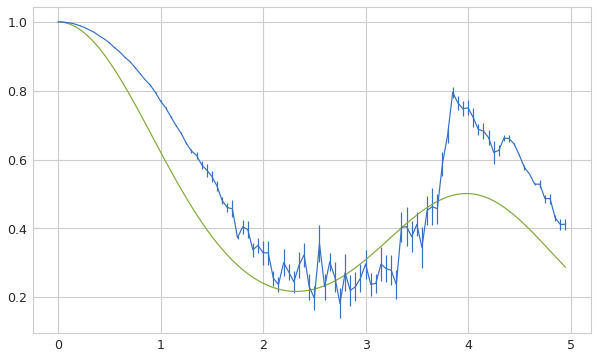

In [40]:
atime = np.arange(Data.shape[0])*0.05

plt.figure(figsize=(10,6))
plt.errorbar(atime, Data[:,0,0], yerr=Data[:,0,1])
plt.plot(atime, Data_cl[:,0])
plt.show()

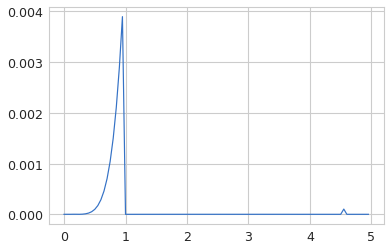

In [43]:
plt.figure()
plt.plot(atime, Dists)
plt.show()